# Test Overlap between sources in a blend

In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


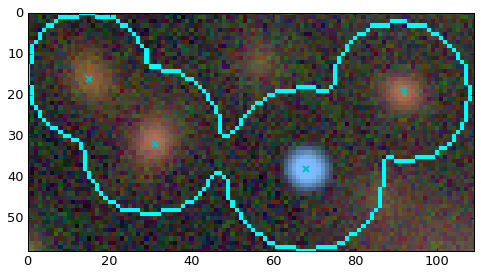

In [2]:
# Load the data
dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"), 'sim_data'))
filters = ["u", "g", "r", "i", "z", 'y']
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename, useExactPeaks=True)
#pidx = 3
#condition = (expDb.mergedTable["peaks"]<=10) & (expDb.mergedTable["peaks"]>1)
pidx = 2
condition = None#(expDb.mergedTable["peaks"]<=5) & (expDb.mergedTable["peaks"]>1)
footprint, peaks = expDb.getParentFootprint(parentIdx=pidx, condition=condition, display=True)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

In [3]:
np.random.seed(1)
img_peaks = peaks + np.random.rand(*peaks.shape)-.5

In [14]:
e_rel = 1e-2
deblend.initNMF();
result = deblend.deblend(
    display=False,
    max_iter=500,
    constraints="S",
    strict_constraints="m",
    usePsf=False,
    e_rel=e_rel,
    monotonicUseNearest=True,
    l0_thresh=.35,
    traceback=True,
    txy_wait=10,
    peaks=img_peaks,
    txy_skip=20
)

INFO:proxmin.algorithms:Completed 501 iterations
INFO:lsst.meas.deblender.proximal:Total Runtime: 7.01 s


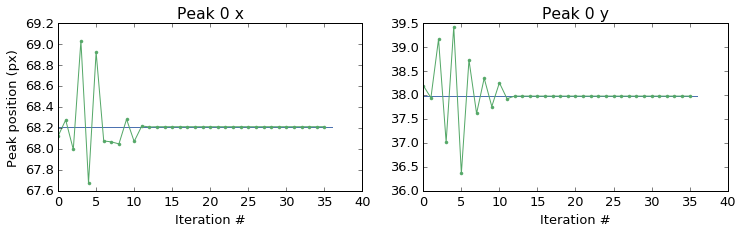

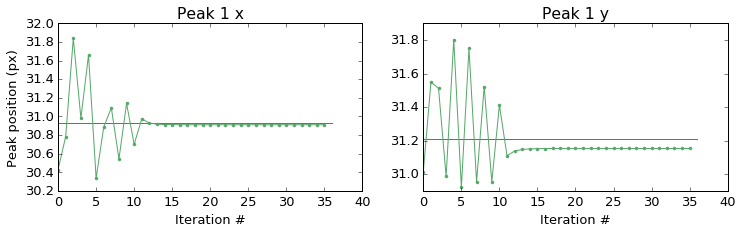

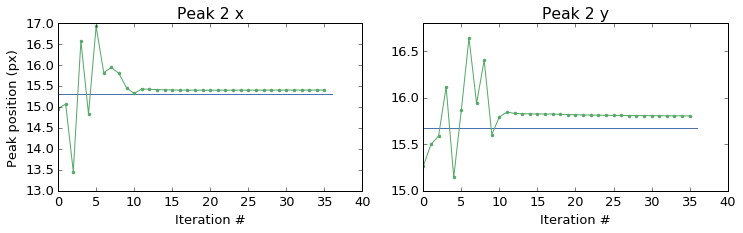

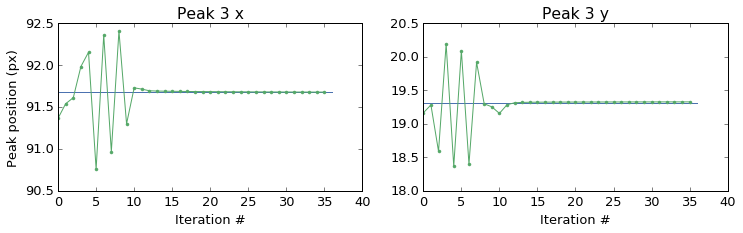

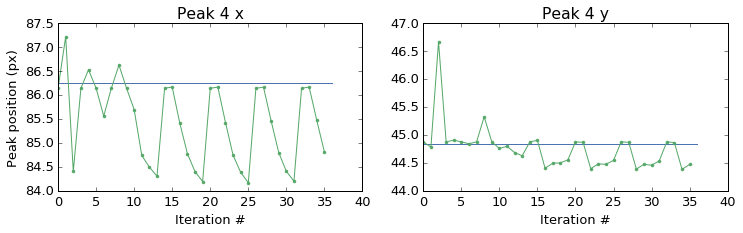

In [15]:
px_hist, py_hist = result.T.get_history()
adjusted_peaks = deblend.peaksToBbox(peaks)
model = result.get_model(combine=True)
img_shape = result.shape
cx, cy = int(img_shape[1]/2), int(img_shape[0]/2)
for k in range(len(peaks)):
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot([0,px_hist.shape[0]],[adjusted_peaks[k][0],adjusted_peaks[k][0]])
    ax1.plot(cx-px_hist[:,k], '.-')
    ax1.set_title("Peak {0} x".format(k))
    ax1.set_xlabel("Iteration #")
    ax1.set_ylabel("Peak position (px)")
    ax2.plot([0,py_hist.shape[0]],[adjusted_peaks[k][1],adjusted_peaks[k][1]])
    ax2.plot(cy-py_hist[:,k], '.-')
    ax2.set_title("Peak {0} y".format(k))
    ax2.set_xlabel("Iteration #")
    plt.show()

In [16]:
import scipy.sparse
import proxmin
import deblender

A = result.A
S = result.S

Ahist = result.get_history("A")
Shist = result.get_history("S")
# Indices of Ahist are iteration, Band, Peak
print(Ahist["X"][0].shape)
# indices of Shist are iteration, Peak, Pixel
print(Shist["X"][0].shape)

B, N, M = deblend.data.shape

# Errors in A
eye = scipy.sparse.eye(B,B)
e_A = np.array([list(proxmin.utils.get_variable_errors(eye,
                                                       Ahist["X"][0][i],
                                                       Ahist["Z"][0][i],
                                                       Ahist["U"][0][i],
                                                       e_rel))
                for i in range(len(Ahist["X"][0]))])
e_pri2A = e_A[:,0]
e_dual2A = e_A[:,1]

# Errors in S
L_symm = result.parameters["Ls"][1][0]
L_symmX = np.array([L_symm.dot(X) for X in Shist["X"][0]])
e_S = np.array([list(proxmin.utils.get_variable_errors(L_symm,
                                                       L_symmX[i],
                                                       Shist["Z"][0][i],
                                                       Shist["U"][0][i],
                                                       e_rel))
                for i in range(len(Ahist["X"][0]))])
e_pri2S = e_S[:,0]
e_dual2S = e_S[:,1]

(501, 6, 5)
(501, 5, 6549)


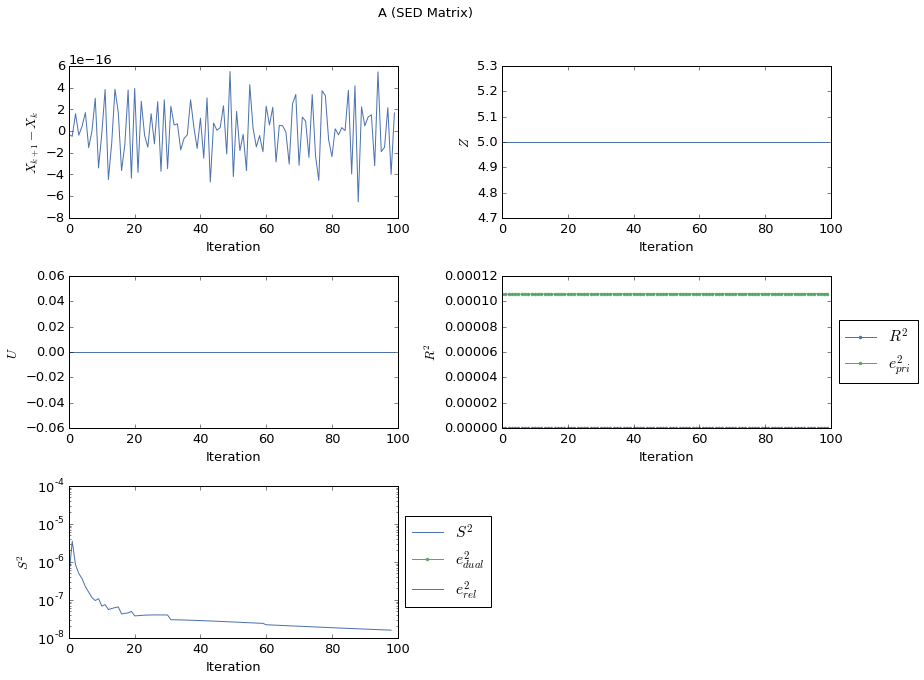

In [17]:
fig = plt.figure(figsize=(12,9))
ax = [fig.add_subplot(3,2,n+1) for n in range(5)]
fig.suptitle("A (SED Matrix)", y=1.05)

ax[0].plot(np.sum((Ahist["X"][0][1:]-Ahist["X"][0][:-1])[:100], axis=(1,2)))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$X_{{k+1}}-X_k$")

ax[1].plot(np.sum(Ahist["Z"][0][:100], axis=(1,2)))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$Z$")

ax[2].plot(np.sum(Ahist["U"][0][:100], axis=(1,2)))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("$U$")

ax[3].plot([proxmin.utils.l2sq(R) for R in Ahist["R"][0][:100]], '.-', label="$R^2$")
ax[3].plot(e_pri2A[:100], '.-', label="$e_{{pri}}^2$")
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("$R^2$")

ax[4].semilogy([proxmin.utils.l2sq(S) for S in np.array(Ahist["S"][0][1:100].tolist())], label="$S^2$")
ax[4].plot(e_dual2A[:100], '.-', label="$e_{{dual}}^2$")
ax[4].plot([0,99],[e_rel**2,e_rel**2], label="$e_{{rel}}^2$")
ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[4].set_xlabel("Iteration")
ax[4].set_ylabel("$S^2$")

plt.tight_layout()
plt.show()

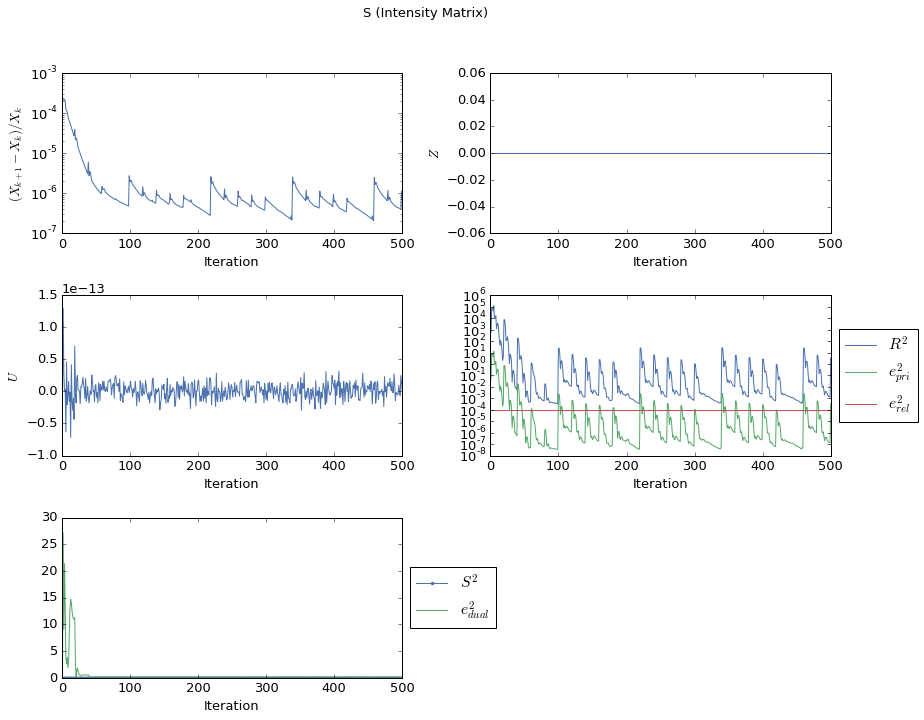

In [18]:
fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(4,2,n+1) for n in range(5)]
fig.suptitle("S (Intensity Matrix)", y=1.05)


ax[0].semilogy(np.sum(np.abs((Shist["X"][0][1:]-Shist["X"][0][:-1])), axis=(1,2))/np.sum(Shist["X"][0][1:]))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$(X_{{k+1}}-X_k)/X_k$")

ax[1].plot(np.sum(Shist["Z"][0], axis=(1,2)))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$Z$")

ax[2].plot(np.sum(Shist["U"][0], axis=(1,2)))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("$U$")

l2R = np.array([proxmin.utils.l2sq(R) for R in Shist["R"][0]])
ax[3].semilogy(l2R, label="$R^2$")
ax[3].plot(e_pri2S, label="$e_{{pri}}^2$")
ax[3].plot([0,len(Shist["X"][0])-1],[e_rel**2,e_rel**2], label="$e_{{rel}}^2$")
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].set_xlabel("Iteration")

ax[4].plot([proxmin.utils.l2sq(S) for S in np.array(Shist["S"][0].tolist())], '.-', label="$S^2$")
ax[4].plot(e_dual2S, label="$e_{{dual}}^2$")
ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[4].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

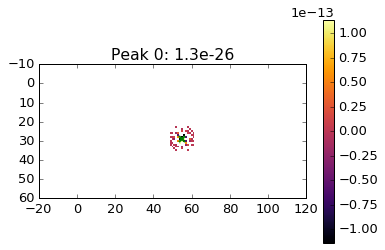

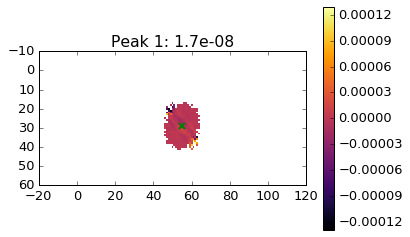

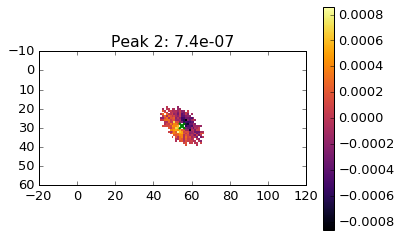

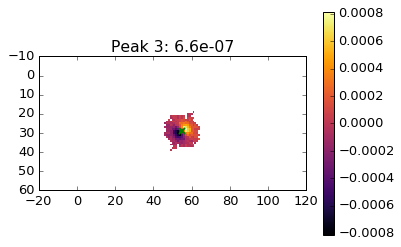

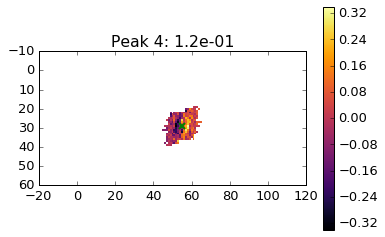

In [19]:
mask = deblend.mask[0].astype(int)
for k in range(len(peaks)):
    d = L_symm.dot(S)[k]
    d = np.ma.array(d, mask=d==0)
    plt.imshow(d.reshape(N,M))
    plt.plot(cx,cy, 'gx', mew=2)
    plt.colorbar()
    max_diff = np.ma.max(np.abs(d))
    if max_diff is np.ma.masked:
        max_diff = 0
    plt.title("Peak {0}: {1:.1e}".format(k, max_diff**2))
    plt.show()

INFO:lsst.meas.deblender:7


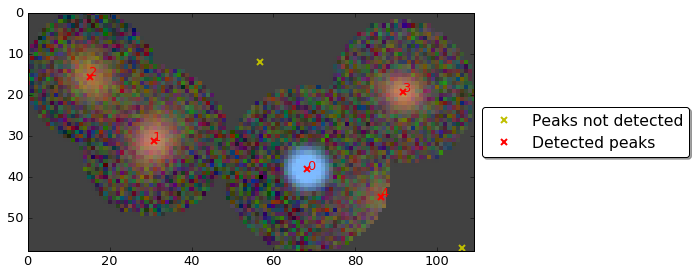

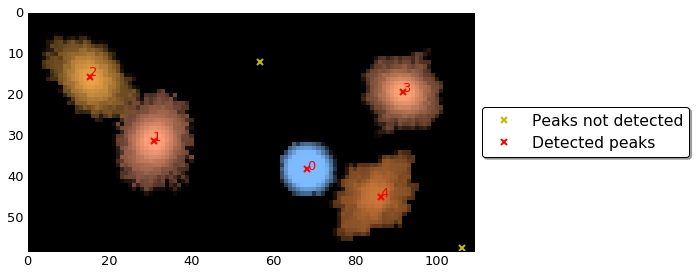

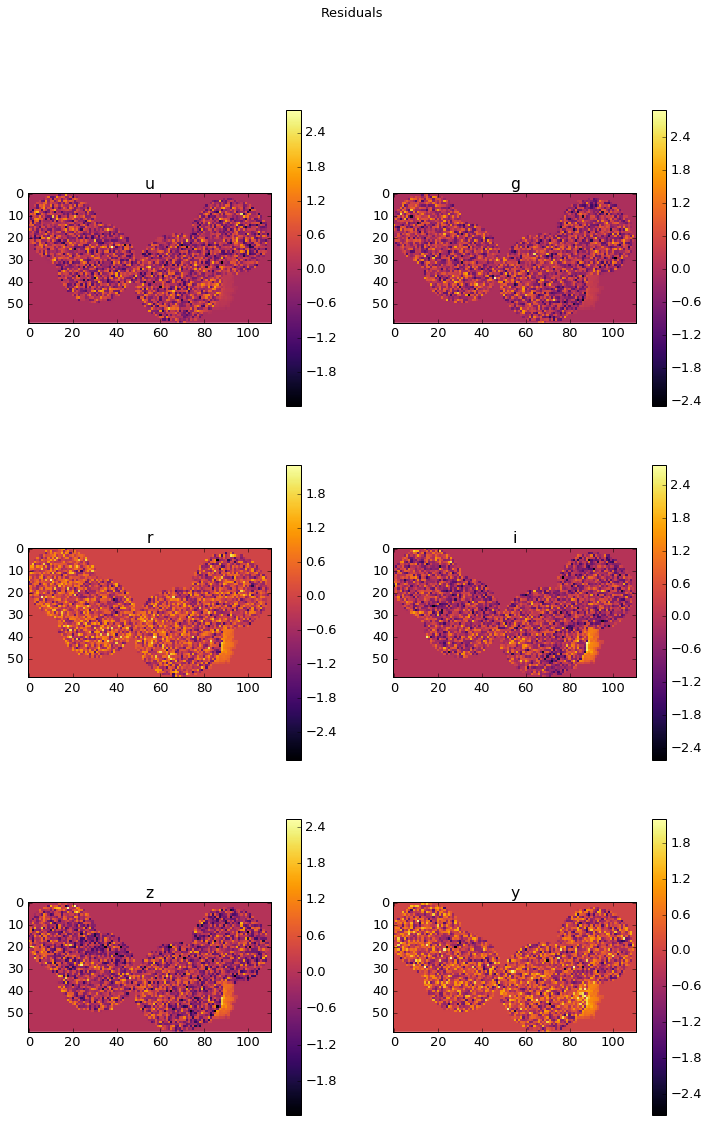

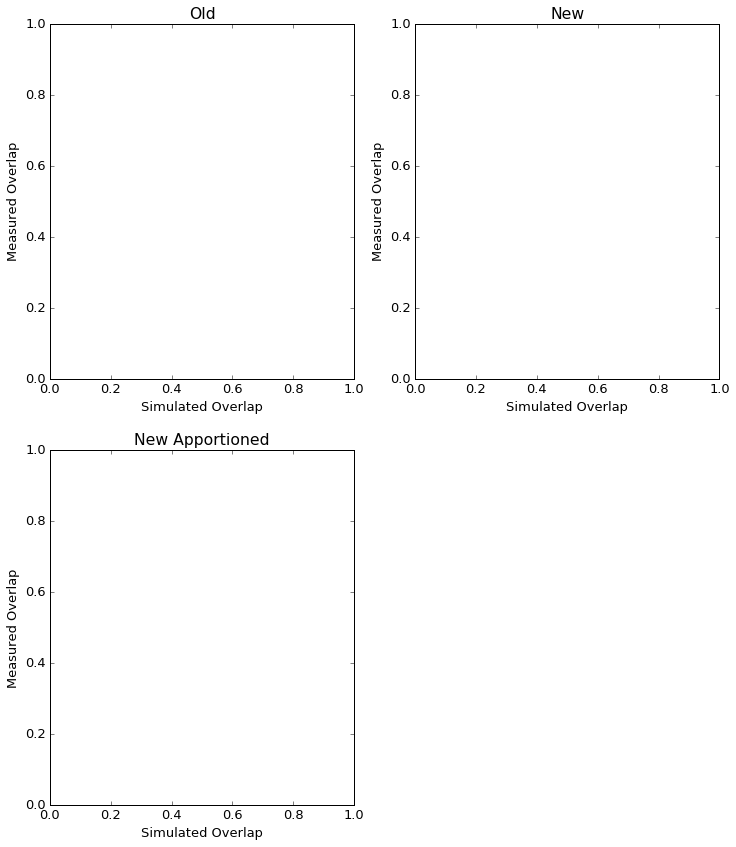

INFO:lsst.meas.deblender:Peak 0


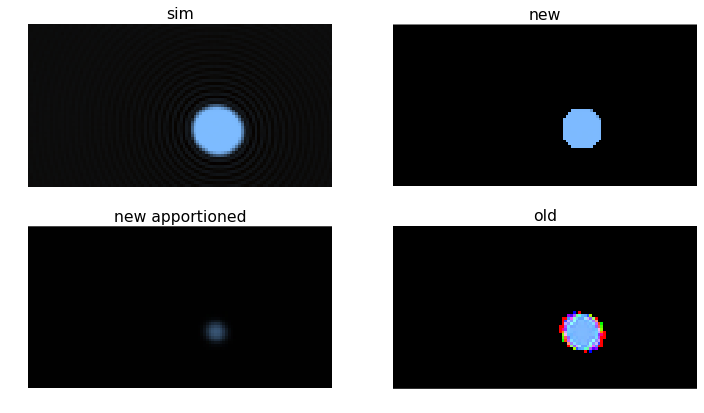

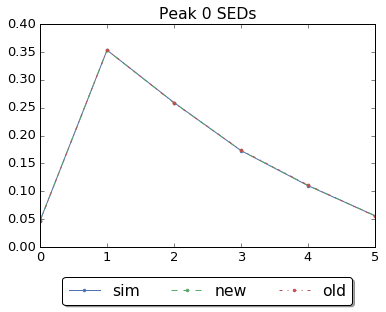

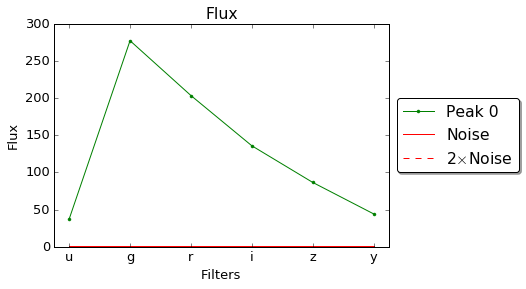

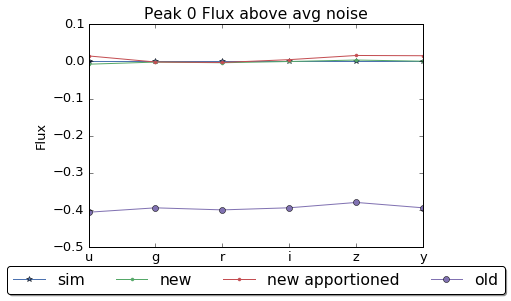

INFO:lsst.meas.deblender:Peak 1


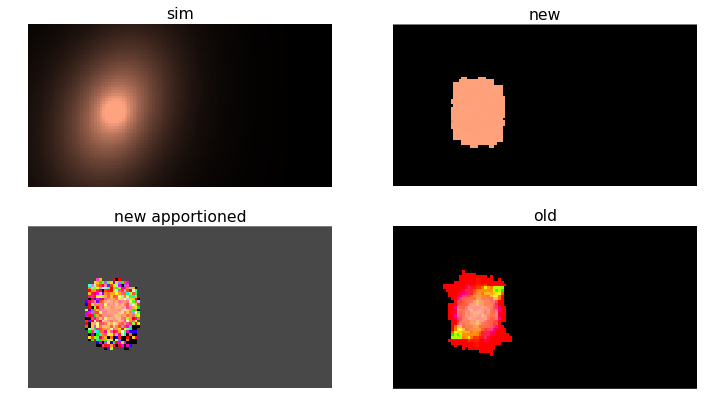

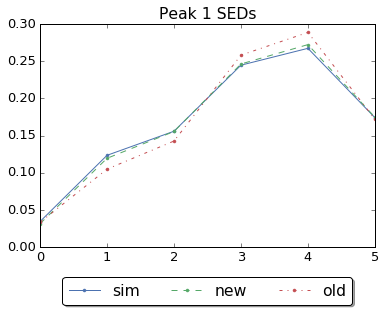

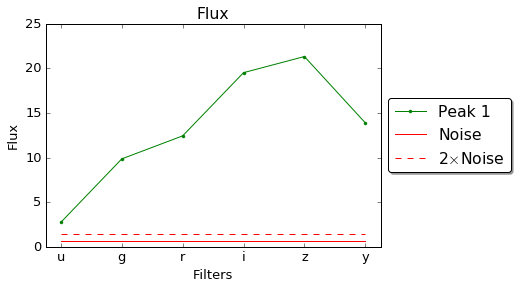

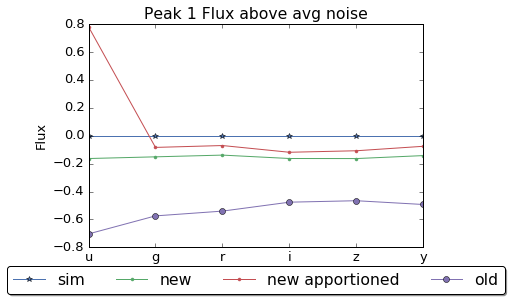

INFO:lsst.meas.deblender:Peak 2


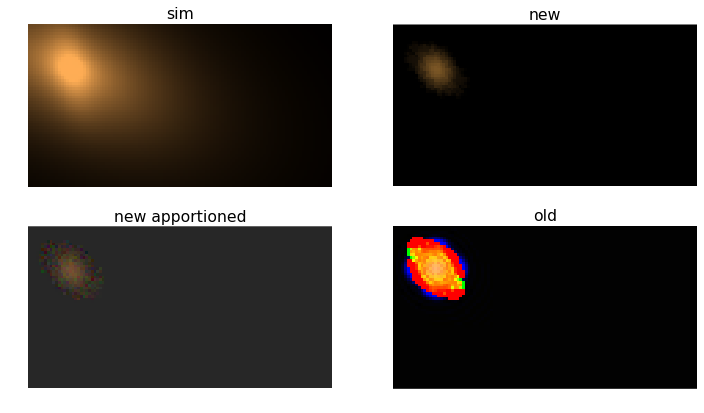

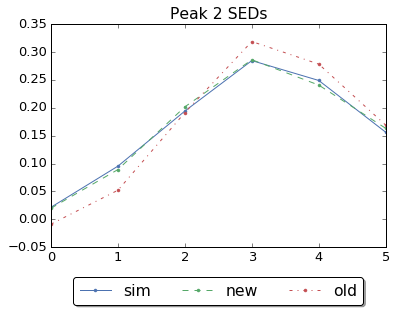

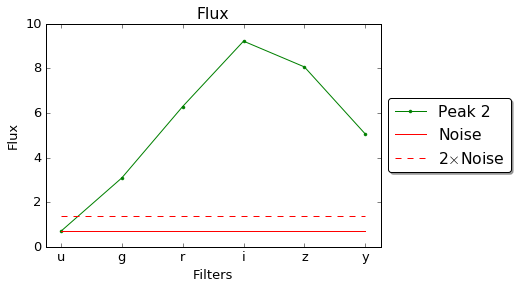

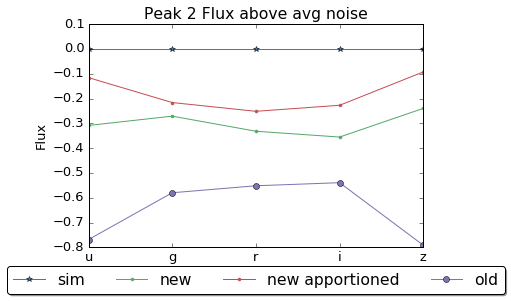

INFO:lsst.meas.deblender:Peak 3


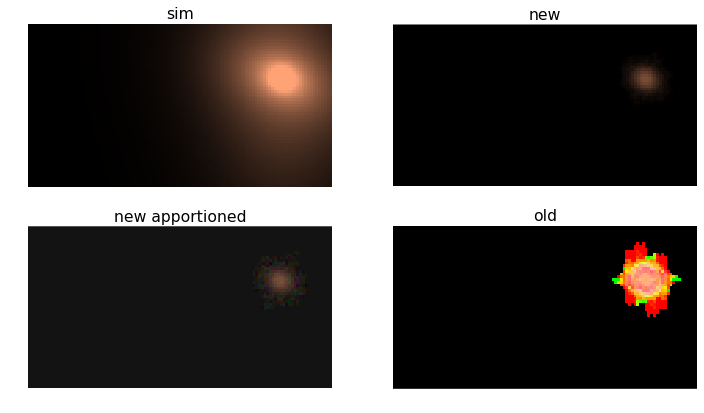

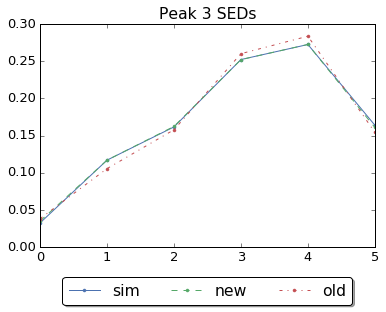

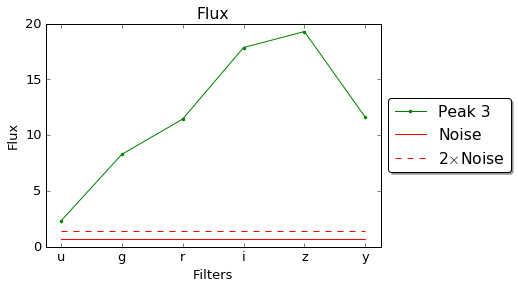

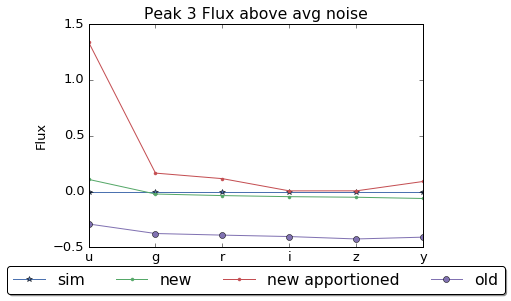

INFO:lsst.meas.deblender:Peak 4


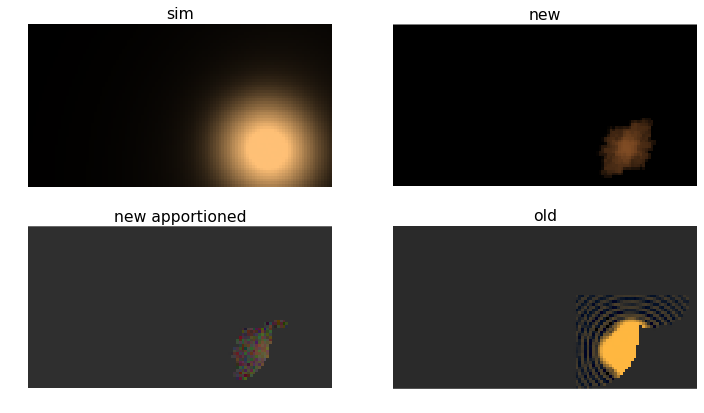

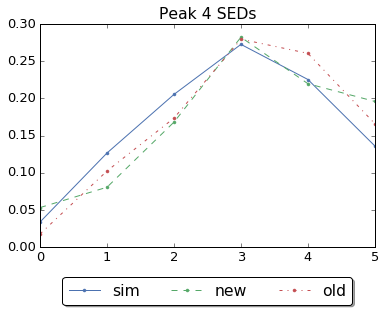

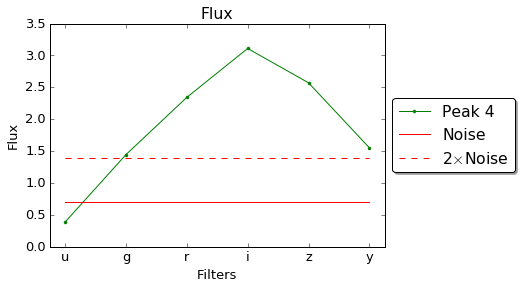

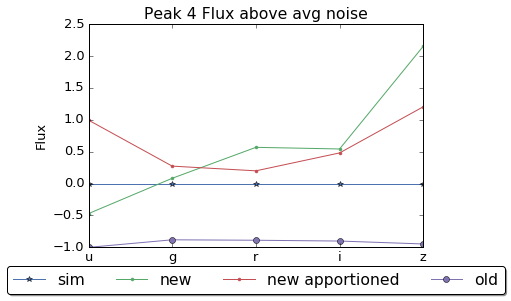

In [20]:
sim.compareDeblendToSim(deblend, expDb.mergedDet[pidx], expDb.simTable)